In [1]:
import os
GPU_id = 3
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import sys
sys.path.insert(1, '../')

In [3]:
import torch
import pandas as pd
import numpy as np
from time import time 

from fastai import *
from fastai.basic_data import *
from fastai.basic_data import *
from fastai.tabular import *
from fastai.basic_data import DataBunch
from fastai.tabular import TabularModel

import cudf

from nv_tabular.preproc import Workflow, get_new_list_config
from nv_tabular.ops import Normalize, FillMissing, Categorify, Moments, Median, Encoder, LogOp, ZeroFill
from nv_tabular.dl_encoder import DLLabelEncoder
from nv_tabular.ds_iterator import GPUDatasetIterator
from nv_tabular.batchloader import FileItrDataset, DLCollator, DLDataLoader
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice/.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


In [4]:
torch.__version__, cudf.__version__

('1.5.0.dev20200224', '0.13.0a+2514.g446009365')

In [5]:
%load_ext snakeviz
# load snakeviz if you want to run profiling

In [6]:
# to_cpu = True

<h3> Dataset Gathering: Define files in the training and validation datasets. </h3>

In [7]:
# data_path = '/rapids/notebooks/jperez/Documents/ds-itr/examples/'
data_path = '/datasets/outbrain/jp_out/output/'
#df_test = 'test/'
df_valid = 'validation_feature_vectors_integral.csv/'
df_train = 'train_feature_vectors_integral_eval.csv/'

train_set = [data_path + df_train + x for x in os.listdir(data_path + df_train) if x.startswith("part")] 
valid_set = [data_path + df_valid + x for x in os.listdir(data_path + df_valid) if x.startswith("part")] 

In [8]:
len(train_set), len(valid_set)

(5, 100)

<h4>Grab column information</h4>

In [9]:
cols = open(data_path + 'train_feature_vectors_integral_eval.csv.header').read().splitlines()

In [10]:
cat_names = ['display_id', 'is_leak', 'doc_event_id', 'ad_id', 'doc_id', 'doc_ad_entity_id', 'doc_event_entity_id', 'doc_event_entity_id', 'doc_ad_source_id', 'doc_event_source_id', 'event_geo_location', 'ad_advertiser', 'event_country_state', 'doc_ad_publisher_id', 'doc_event_publisher_id', 'doc_ad_topic_id', 'doc_event_topic_id', 'event_country', 'doc_ad_category_id', 'doc_event_category_id', 'event_hour', 'event_platform', 'traffic_source', 'event_weekend', 'user_has_already_viewed_doc']
cont_names =  ['pop_ad_id_conf', 'pop_document_id_conf', 'user_doc_ad_sim_categories_conf', 'user_doc_ad_sim_topics_conf', 'pop_publisher_id_conf', 'pop_advertiser_id_conf', 'pop_campaign_id_conf', 'pop_source_id_conf', 'pop_entity_id_conf', 'pop_topic_id_conf', 'pop_category_id_conf', 'pop_ad_id', 'pop_document_id', 'pop_publisher_id', 'pop_advertiser_id', 'pop_campaign_id', 'pop_source_id', 'pop_entity_id', 'pop_topic_id', 'pop_category_id', 'user_doc_ad_sim_categories', 'user_doc_ad_sim_topics', 'user_doc_ad_sim_entities', 'doc_event_doc_ad_sim_categories', 'doc_event_doc_ad_sim_topics', 'doc_event_doc_ad_sim_entities', 'user_views', 'ad_views', 'doc_views', 'doc_event_days_since_published', 'doc_event_hour', 'doc_ad_days_since_published'] #+ [i for i in ds.columns if i not in cat_names and i not in ['label']]
cat_names = [name for name in cat_names if name in cols]
cont_names = [name for name in cont_names if name in cols]


<h3>Preprocessing:</h3> <p>Select operations to perform, create the Preprocessor object, create dataset iterator object and collect the stats on the training dataset</p>

In [11]:
config = get_new_list_config()
config["PP"]["continuous"] = [[FillMissing(), Normalize()]]
config["PP"]["categorical"] = [Categorify()]

In [12]:
%%time
proc = Workflow(cat_names=cat_names, cont_names=cont_names, label_name=['label'], config=config, to_cpu=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 124 µs


In [13]:
%%time
trains_itrs = GPUDatasetIterator(train_set,names=cols, engine='csv')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs


In [14]:
%%time
proc.update_stats(trains_itrs)

CPU times: user 13.3 s, sys: 9.68 s, total: 23 s
Wall time: 24.4 s


In [15]:
proc.stats["categories"], proc.columns_ctx['categorical']['Categorify']

({'display_id': 290161,
  'is_leak': 2,
  'doc_event_id': 92373,
  'ad_id': 103966,
  'doc_id': 46250,
  'doc_ad_source_id': 5202,
  'doc_event_source_id': 4655,
  'event_geo_location': 1264,
  'ad_advertiser': 3438,
  'event_country_state': 965,
  'doc_ad_publisher_id': 690,
  'doc_event_publisher_id': 898,
  'event_country': 201,
  'event_hour': 7,
  'event_platform': 4,
  'traffic_source': 4,
  'event_weekend': 3,
  'user_has_already_viewed_doc': 3},
 ['display_id_Categorify',
  'is_leak_Categorify',
  'doc_event_id_Categorify',
  'ad_id_Categorify',
  'doc_id_Categorify',
  'doc_ad_source_id_Categorify',
  'doc_event_source_id_Categorify',
  'event_geo_location_Categorify',
  'ad_advertiser_Categorify',
  'event_country_state_Categorify',
  'doc_ad_publisher_id_Categorify',
  'doc_event_publisher_id_Categorify',
  'event_country_Categorify',
  'event_hour_Categorify',
  'event_platform_Categorify',
  'traffic_source_Categorify',
  'event_weekend_Categorify',
  'user_has_already_vie

<h5>Gather embeddings using statistics gathered in the Read phase.</h5>

In [16]:
embeddings = [x[1] for x in proc.df_ops['Categorify'].get_emb_sz(proc.stats["categories"], proc.columns_ctx['categorical']['base'])]

In [17]:
embeddings

[(103967, 16),
 (3439, 16),
 (290162, 16),
 (92374, 16),
 (46251, 16),
 (5203, 16),
 (4656, 16),
 (691, 16),
 (899, 16),
 (1265, 16),
 (966, 16),
 (202, 16),
 (8, 5),
 (5, 4),
 (4, 3),
 (3, 3),
 (5, 4),
 (4, 3)]

<h5>Create the file iterators using the FileItrDataset Class.</h5>

In [18]:
%%time
t_batch_sets = [FileItrDataset(x, names=cols, engine='csv', batch_size=400000) for x in train_set]
v_batch_sets = [FileItrDataset(x, names=cols, engine='csv', batch_size=400000) for x in valid_set]

CPU times: user 14.6 s, sys: 13.2 s, total: 27.8 s
Wall time: 28 s


In [19]:
%%time
t_chain = torch.utils.data.ChainDataset(t_batch_sets)
v_chain = torch.utils.data.ChainDataset(v_batch_sets)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 39.6 µs


In [20]:
proc.columns_ctx['final']['ctx']

{'continuous': ['Normalize'],
 'categorical': ['Categorify'],
 'label': ['label']}

<h5>Use the Deep Learning Collator to create a collate function to pass to the dataloader.</h5>

In [21]:
%%time
dlc = DLCollator(preproc=proc)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


In [22]:
%%time
t_data = DLDataLoader(t_chain, collate_fn=dlc.gdf_col, pin_memory=False, num_workers=0)
v_data = DLDataLoader(v_chain, collate_fn=dlc.gdf_col, pin_memory=False, num_workers=0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 185 µs


<h4>After creating the Dataloaders you can leverage fastai framework to create Machine Learning models</h4>

In [23]:
databunch = DataBunch(t_data, v_data, collate_fn=dlc.gdf_col, device="cuda")

In [24]:
%%time
model = TabularModel(emb_szs = embeddings, n_cont=len(cont_names), out_sz=2, layers=[512,256])

learn =  Learner(databunch, model, metrics=[accuracy])
learn.loss_func = torch.nn.CrossEntropyLoss()


CPU times: user 6.26 s, sys: 644 ms, total: 6.91 s
Wall time: 235 ms


In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-01
Min loss divided by 10: 2.51E-02


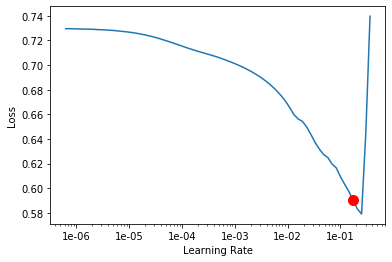

In [26]:
learn.recorder.plot(show_moms=True, suggestion=True)

In [27]:
learning_rate = 2.75e-2
epochs = 1

In [28]:
start = time()
learn.fit_one_cycle(epochs,learning_rate)
t_final = time() - start 

epoch,train_loss,valid_loss,accuracy,time
0,1.094297,1.207826,0.510628,02:19


In [29]:
del learn 
del model
del databunch
torch.cuda.empty_cache() 